Capstone #4 - Unsupervised Learning

For my second capstone, I chose to use the same dataset as my previous capstone. When I first envisioned the previous capstone, I thought about using the data to create a classifier which would predict pitch type. This wasn't very useful as many of the independent variables could only be collected after the pitch, and pitch type is mostly an arbitrary classification anyway. Because of this I decided to predict location which made for an easier classification problem with value.

After learning about the goals and methods of unsupervised learning, I realized that the pitch type problem might be better suited as a clustering algorithm, since the pitch type is (as stated above) essentially an arbitrary classification of a pitch based on similar characteristics. This became the goal of this project: to determine if a clustering algorithm would cluster pitches in a way similar to the arbitrary classifications of pitches by type, or if the characteristics of pitches lend themselves to different clusters than the arbitrary designations assigned to them.

As before, column information is partially provided from the original kaggle dataset (https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv). 

Columns with asterisks are defined at https://baseballsavant.mlb.com/csv-docs, https://trackman.zendesk.com/hc/en-us/articles/115002776647-Radar-Measurement-Glossary-of-Terms, and https://fastballs.wordpress.com/category/pitchfx-glossary/. Some definitions modified for clarity by me. 

1. px: x-location as pitch crosses the plate. X=0 means right down the middle
2. pz: z-location as pitch crosses the plate. Z=0 means the ground
3. start_speed: Speed of the pitch upon release by the pitcher (as it's thrown)
4. end_speed: Speed of the pitch when it crosses the front edge of the plate
5. spin_rate: The pitch's spin rate, measure in RPM
6. spin_dir: Direction in which pitch is spinning, measured in degrees (assuming 0 is the vector directly between the center of the mound and the center of home plate).
7. *break_angle: (None, deprecated from pre-statcast system, assuming 0 is vertical, angle of vector over break) 
8. *break_length: (None, deprecated from pre-statcast system, magnitude of break vector)
9. *break_y:
10. *ax: The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
11. *ay: The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.
12. *az: The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.
13. *sz_bot: Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.
14. *sz_top: Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
15. type_confidence: Confidence in pitch_type classification. Goes up to 2 for some reason.
16. *vx0: The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet.
17. *vy0: The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet.
18. *vz0: The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet.
19. x
20. x0: the left/right distance, in feet, of the pitch, measured at the initial point.
21. y
22. *y0: the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters. This parameter has been variously set at 40, 50, or 55 feet (and in a few instances 45 feet) from the plate at different times throughout the 2007 season as Sportvision experiments with optimal settings for the PITCHf/x measurements. Sportvision settled on 50 feet in the second half of 2007, and this value of y0=50 feet has been used since. Changes in this parameter impact the values of all other parameters measured at the release point, such as start_speed.
23. *z0:  the height, in feet, of the pitch, measured at the initial point.
24. *pfx_x: Horizontal movement in feet from the catcher's perspective.
25. *pfx_z: Vertical movement in feet from the catcher's perspective.
26. nasty
27. *zone: Zone location of the ball when it crosses the plate from the catcher's perspective. 1-9 are in zone, left to right, then high to low. 11 is up and left of the zone, 12 is up and right of the zone, 13 and 14 are same for low
28. code: Records the result of the pitch. See dataset description for list of codes and their meaning
29. type: Simplified code, S (strike) B (ball) or X (in play)
30. pitch_type: Type of pitch. See dataset description for list of pitch types
31. event_num: event number, used for finding when exactly ejections happen.
32. b_score: score for the batter's team
33. ab_id: at-bat ID. Matches up with atbats.csv
34. b_count: balls in the current count
35. s_count: strikes in the current count
36. outsnumber of outs (before pitch is thrown)
37. pitch_num: pitch number (of at-bat)
38. on_1b: True if there's a runner on first, False if empty
39. on_2b: True if there's a runner on second, False if empty
40. on_3b: I don't know (/s. True if there's a runner on third, False if empty)

In [1]:
# Import required packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

pitches = pd.read_csv('/Users/JKovach/Downloads/mlb-pitch-data-20152018/pitches.csv')

# Sample 1,000 pitches to increase performance, nan < 1% of values, drop nan
no_samples = 1000
pitches = pitches.sample(n=no_samples, random_state=0)
pitches = pitches.dropna(how='any')

# Remove gimmick and intentional pitches, then define fastball or offspeed
pitches = pitches[~pitches['pitch_type'].isin(['PO', 'FO', 'IN', 'UN', 'EP', 'SC', 'KN', 'KC'])]
fastball = ['FF', 'FT', 'FS', 'FC']
def fastbool(x):
    if x in fastball:
        return 1
    else:
        return 0
    
pitches['is_fastball'] = pitches['pitch_type'].apply(fastbool)

# Convert target to numerical
num = LabelEncoder()
pitches['n_pitch_type'] = num.fit_transform(pitches['pitch_type'])

# Drop variables unrelated to the characteristics of the pitch
pitches = pitches.drop(['y0', 'b_score', 'ab_id', 'b_count', 's_count', 'zone', 'code', 'type', 'sz_top', 
                        'sz_bot', 'event_num', 'outs', 'on_1b', 'on_2b', 'on_3b', 'pitch_num', 'pitch_type'], 1)
pitches.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,vz0,x,x0,y,z0,pfx_x,pfx_z,nasty,is_fastball,n_pitch_type
1304190,-0.191000,1.72400,94.8,87.6,2332.035,193.484,18.1,2.7,23.8,-5.194000,...,-9.574000,124.28,-1.777000,192.23,5.918000,-2.660000,11.050000,57.0,1,3
612631,-0.444000,2.18700,95.0,86.8,2577.683,216.944,42.5,4.1,23.7,-14.833000,...,-7.915000,133.92,-2.085000,179.73,5.917000,-7.650000,10.140000,36.0,1,3
1607639,0.167770,1.47883,75.8,69.3,1207.161,332.807,6.7,13.7,23.8,-4.178968,...,0.156760,111.05,2.283996,198.88,5.736771,-3.464456,-6.742686,33.0,0,1
740034,0.086000,1.40200,94.0,86.2,2405.674,201.039,27.4,3.2,23.8,-8.175000,...,-10.297000,113.72,-1.485000,200.93,5.955000,-4.300000,11.150000,57.0,1,3
2591672,0.564738,3.24017,94.8,87.0,2143.277,210.107,29.1,3.8,23.8,-10.214993,...,-5.533289,95.48,-1.312495,151.30,6.249955,-5.288936,9.120988,48.0,1,3


To prepare the data, I import the file, reduce the overall size to 10,000 rows, and drop the NaN values (which account for <1% of the values). I removed esoteric and intentional pitch types, the defined the two target variables. First, as sort of a proof-of-concept, I checked whether such an algorithm could cluster pitches similarly based on these larger groups. I decided that this might be easier for an algorithm to predict given the significant difference in speed and shape of these two types of pitch generally. 

Second, I wanted to proceed to my actual goal of trying to accurately cluster pitch types. I predicted that they would cluster similarly based on speed and shape. First I tried K-Means:

[81.01 91.93]


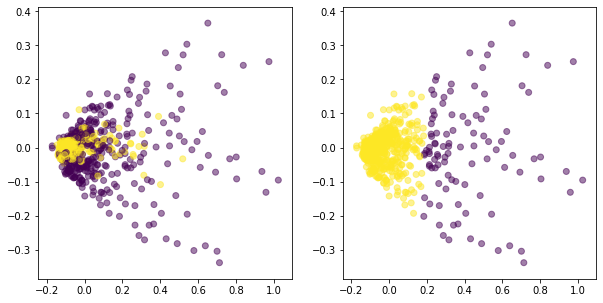

col_0         0    1
is_fastball         
0            88  376
1            13  492


In [2]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

# Define features and outcome
X = pitches.iloc[:, :23]
y = pitches.iloc[:, 23]

# Normalize, fit, and create predictions
X_norm = normalize(X)
y_pred = KMeans(n_clusters=2, random_state=34).fit_predict(X_norm)

# Reduce to two components for graphical purposes
pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

# Plot ground truth versus clustering solution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.5)
plt.show()

print(pd.crosstab(y, y_pred))

In [3]:
import itertools
from sklearn.metrics import pairwise_distances

# Adjusted Rand Index
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, y_pred)))

# Silhouette Coefficients
sample_split = no_samples/4
X1 = pitches.sample(n=int(sample_split), random_state=0)
X2 = pitches.sample(n=int(sample_split), random_state=1)
X3 = pitches.sample(n=int(sample_split), random_state=2)
X4 = pitches.sample(n=int(sample_split), random_state=3)

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=2).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

Adjusted Rand Score: 0.0374020870650898
0.5967757569480251
0.5799812836422193
0.6015878924133524
0.6122201593480135


Our initial model performs poorly. I suspected that this was because of two factors. First, the data in the ground truth has significant overlap and second, it looks as though the clusters in the ground truth have uneven variance. While exploring other clustering solutions, I noticed many of them use StandardScaler instead of a normalizing function, so I decided to first try this small change and note the result.

[32.42 49.79]


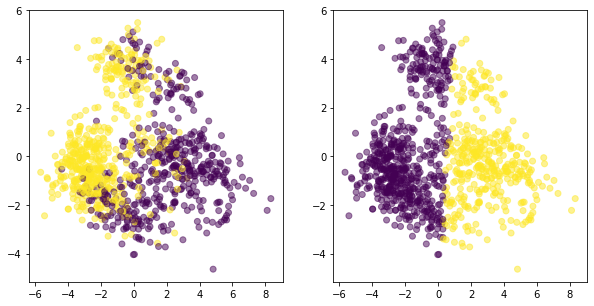

col_0          0    1
is_fastball          
0            137  327
1            459   46
Adjusted Rand Score: 0.3865889008900961


In [4]:
# This time we substitute StandardScaler
X_norm = StandardScaler().fit_transform(X)
y_pred = KMeans(n_clusters=2, random_state=34).fit_predict(X_norm)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.5)
plt.show()

print(pd.crosstab(y, y_pred))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, y_pred)))

StandardScaler appears to drastically improve model performance. In my previous capstone, I noted that most of the variables were either normally distributed or followed and f distribution. I suspect that the reason scaling improves performace is because the normalize function compresses most of the f-distributed data into the lower percentiles and leaves outliers in the higher percentiles. 

With StandardScaler, it appears the model assigns the majority of points to the opposite clusters, while maintaining pairwise relationships between the ground truth and new solution. The rand index for this model is roughly random, but the adjusted rand index indicates this solution is functioning well above pure randomness.

To further improve performance, I eliminated the outliers.

969

For: px
Min Value = -3.2584226517376 | Max Value = 2.5551369477614103
Low Range = -2.437737978873975 | High Range = 2.4468966314566254
Number of outliers is: 3
Percentage of outliers is: 0.0030959752321981426

For: pz
Min Value = -0.937424748115681 | Max Value = 6.27916375128479
Low Range = -0.04902680714889951 | High Range = 4.54661606012502
Number of outliers is: 27
Percentage of outliers is: 0.02786377708978328

For: start_speed
Min Value = 66.0 | Max Value = 100.1
Low Range = 71.75 | High Range = 104.94999999999999
Number of outliers is: 6
Percentage of outliers is: 0.006191950464396285

For: end_speed
Min Value = 61.3 | Max Value = 91.7
Low Range = 67.35000000000001 | High Range = 95.74999999999999
Number of outliers is: 10
Percentage of outliers is: 0.010319917440660475

For: spin_rate
Min Value = 62.474 | Max Value = 3770.618
Low Range = -317.0459999999998 | High Range = 3747.506
Number of outliers is: 1
Percentage of outliers is: 0.0010319917440660474

For: spin_dir
Min Va

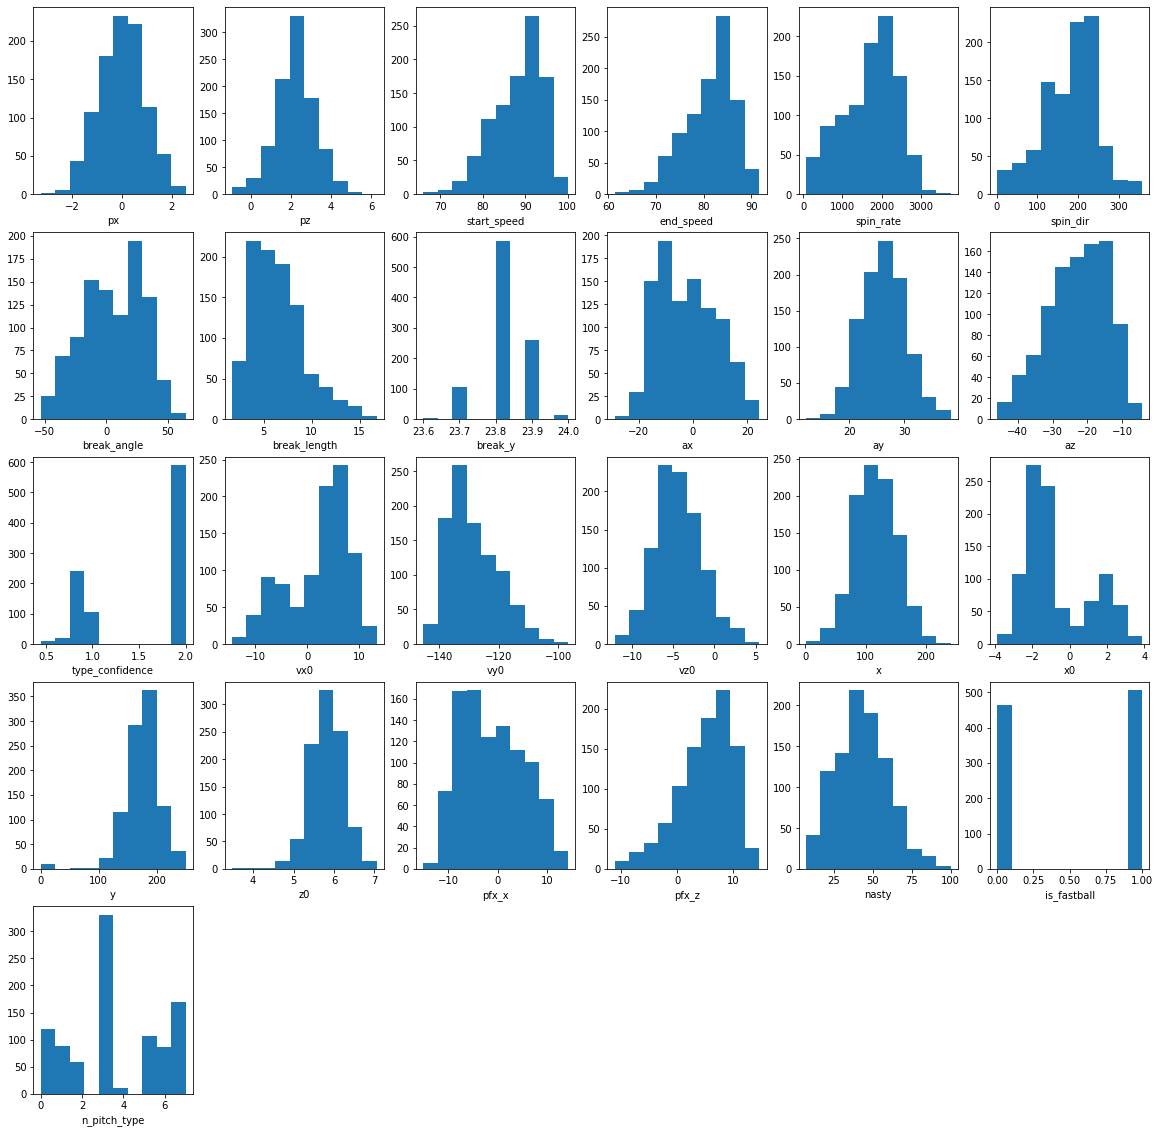

In [5]:
# Get number of samples before outlier elimination, we'll use this later
len1 = pitches.shape[0]
print(len1)

# Check distributions and outliers
plt.figure(figsize=(20,20))
grid = 1

# Plot each feature to grid
for var in list(pitches.columns):
    plt.subplot(5,6,grid)
    plt.hist(pitches[var])
    plt.xlabel(var)
    grid+=1
    
# Check min and max values, outlier range, number and percentage of outliers
for var in list(pitches.columns):   
    print("\nFor: " + var)
    q75, q25 = np.percentile(pitches[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    ol = len(np.where((pitches[var] > max_val) | (pitches[var] < min_val))[0])
    print("Min Value = {} | Max Value = {}".format(min(pitches[var]), max(pitches[var])))
    print("Low Range = {} | High Range = {}".format(min_val, max_val))
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(ol/pitches.shape[0]))

For: px
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pz
Number of outliers is: 25
Percentage of outliers is: 0.025879917184265012
For: start_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: end_speed
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_rate
Number of outliers is: 0
Percentage of outliers is: 0.0
For: spin_dir
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_angle
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 17
Percentage of outliers is: 0.017857142857142856
For: break_y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ax
Number of outliers is: 0
Percentage of outliers is: 0.0
For: ay
Number of outliers is: 0
Percentage of outliers is: 0.0
For: az
Number of outliers is: 0
Percentage of outliers is: 0.0
For: type_confidence
Number of outliers is: 0
Percentage of outliers is: 0.0
For: vx0
Number of outliers is: 0
Percentage of outliers is: 0.0
F

,pz,break_length,y,pfx_z
count,922.000000,922.000000,922.000000,922.000000
mean,2.254568,6.371258,176.011180,5.289489
std,0.978691,2.564116,29.367457,4.682624
min,-0.937425,1.700000,0.000000,-11.114550
25%,1.682687,4.400000,161.312500,2.392500
50%,2.241036,6.000000,177.275000,6.204023
75%,2.823187,7.900000,192.890000,8.833199
max,6.279164,16.800000,249.900000,14.629741


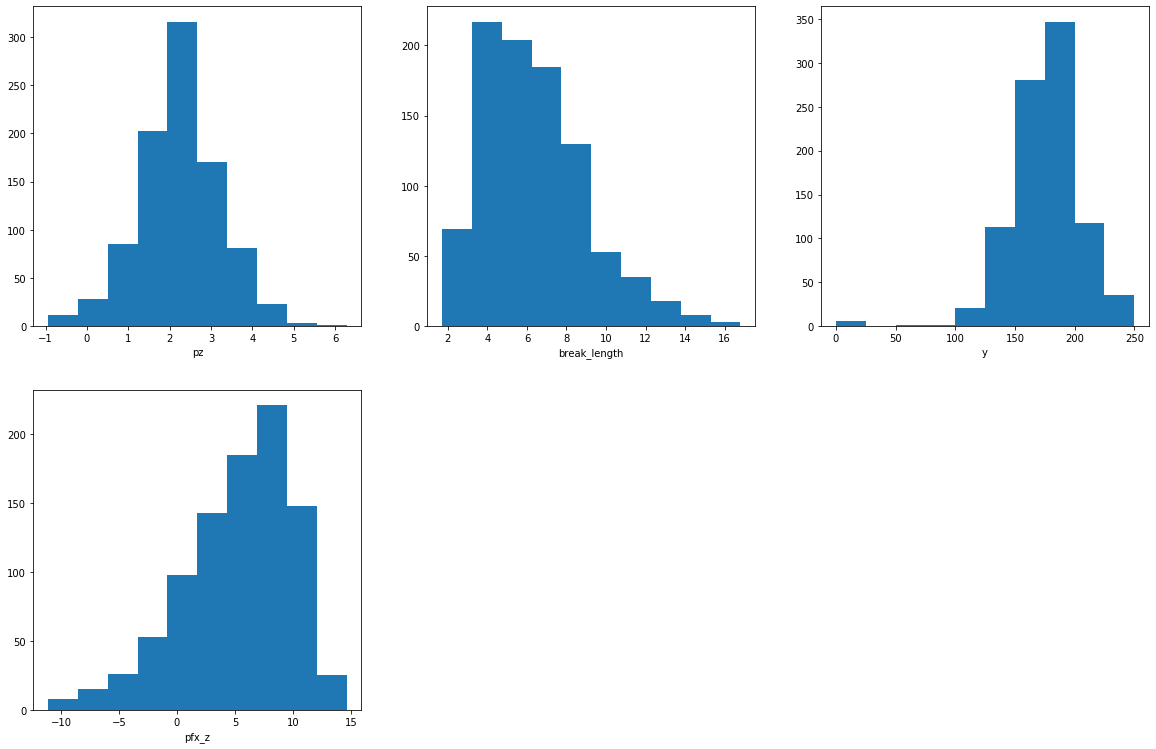

In [6]:
# Set an empty list for variables to check which contain more than 1.5% outliers
check = []

for var in list(pitches.columns):
    print("For: " + var)
    q75, q25 = np.percentile(pitches[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitches[var] > max_val) | (pitches[var] < min_val))[0])
    otl_perc = ol/pitches.shape[0]
    
    # Drops outliers if variable total is less than 1.5%
    if otl_perc < 0.015:
        pitches = pitches[pitches[var]<max_val]
        pitches = pitches[pitches[var]>min_val]
        ol = len(np.where((pitches[var] > max_val) | (pitches[var] < min_val))[0])
        otl_perc = ol/pitches.shape[0]
    
    # Otherwise, append variable to list to check distribution
    else:
        check.append(var)
    
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))

# Check number of remaining samples
print("Samples after dropping outliers: {} of {}".format(pitches.shape[0], len1))
    
# Plot check list distributions
plt.figure(figsize=(20,20))
grid = 1

for var in check:
    plt.subplot(3,3,grid)
    plt.hist(pitches[var])
    plt.xlabel(var)
    grid+=1

pitches[check].describe()

# Some columns with more than 1% outliers are missing. I believe that the previous iterations of the loop
# dropped enough concurrent outliers to drop the percentage of outliers in these columns below 1%

For: pz
Number of outliers is: 0
Percentage of outliers is: 0.0
For: break_length
Number of outliers is: 0
Percentage of outliers is: 0.0
For: y
Number of outliers is: 0
Percentage of outliers is: 0.0
For: pfx_z
Number of outliers is: 0
Percentage of outliers is: 0.0


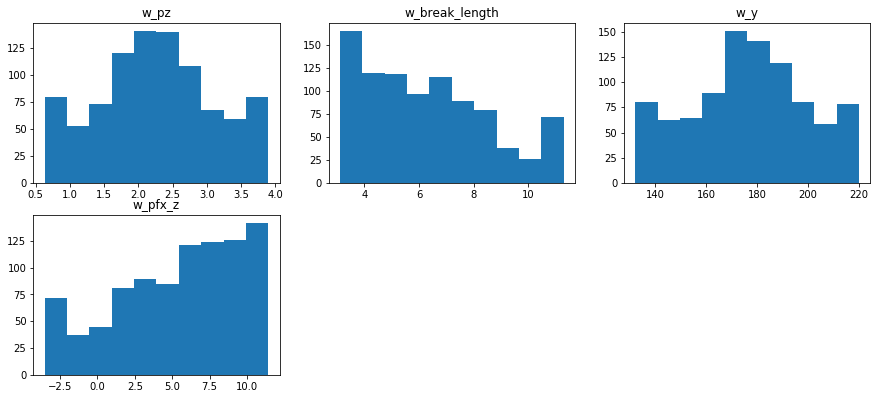

In [7]:
from scipy.stats.mstats import winsorize

plt.figure(figsize=(15,10))
grid = 1

# Winsorizing variables with remaining outliers
for var in check:
    pitches['w_' + var] = winsorize(pitches[var],(0.05, 0.05))
    
    plt.subplot(3,3,grid)
    plt.hist(pitches['w_' + var])
    plt.title('w_' + var)
    grid+=1
    
    print("For: " + var)
    q75, q25 = np.percentile(pitches['w_' + var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((pitches['w_' + var] > max_val) | (pitches['w_' + var] < min_val))[0])
    otl_perc = ol/pitches.shape[0]
    print("Number of outliers is: {}".format(ol))
    print("Percentage of outliers is: {}".format(otl_perc))
    
    pitches = pitches.drop(var, 1)

[32.93 50.37]


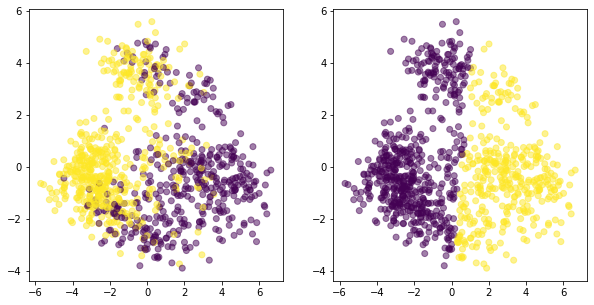

col_0          0    1
is_fastball          
0            115  312
1            446   49
Adjusted Rand Score: 0.41430753967583334
0.5842236992154476
0.5976288617297674
0.6061701859291582
0.6228735552988166


In [8]:
# Re-run model without outliers
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['is_fastball']
X_norm = StandardScaler().fit_transform(X)
y_pred = KMeans(n_clusters=2, random_state=34).fit_predict(X_norm)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.5)
plt.show()

print(pd.crosstab(y, y_pred))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, y_pred)))

X1 = pitches.sample(n=int(sample_split), random_state=0)
X2 = pitches.sample(n=int(sample_split), random_state=1)
X3 = pitches.sample(n=int(sample_split), random_state=2)
X4 = pitches.sample(n=int(sample_split), random_state=3)

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=2).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

As expected, handling the outliers led to a small improvement in the model. The adjusted rand index scores about 3 points higher and the silhouette coefficients indicate we have very dense clusters, which is good. However, since our initial goal was to try and determine pitch type by cluster, I first want to run the model with this multinomial target and determine it's effectiveness.

[32.93 50.37]


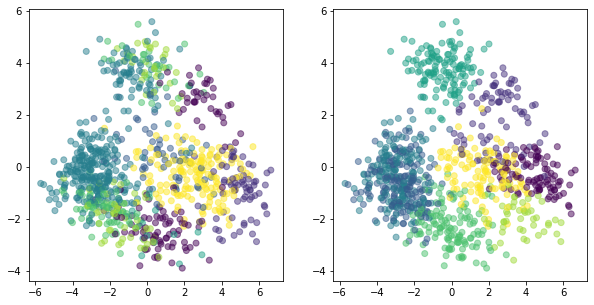

col_0          0   1    2    3   4   5   6   7
n_pitch_type                                  
0              1  37    4    2   2  57   7   3
1             52   0    0    0   0   0  18   2
2              4  12    2    6   4   0   0  30
3              0   5  106  130  71   9   0   3
4              0   0    0    0   0   9   1   0
5              0   5   32   20  24  22   0   0
6              0   2   21    8  27  22   0   2
7             37  17    0    1   0   7  21  77
Adjusted Rand Score: 0.2538651649994173


In [9]:
# Run the same model, this time our ground truth is pitch type instead of 'is_fastball'
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['n_pitch_type']
X_norm = StandardScaler().fit_transform(X)

# Using 8 clusters this time for our 8 pitch types
y_pred = KMeans(n_clusters=8, random_state=34).fit_predict(X_norm)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha=.5)
plt.show()

# Print crosstab and ARI
print(pd.crosstab(y, y_pred))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, y_pred)))

Surprisingly, the model works relatively well on clustering pitch types. Its overall performance could be better, but the performance doesn't degrade too much versus the binary model above. However, I still had to contend with the issue of overlapping features which made me think that maybe other methods of clustering would be better suited for this task.

Initially, I had experimented with removing features based on an intercorrelation threshold. However, subsequent tests of the model reliably demonstrated that more features led to better performance, and fewer features led to worse performance.

For my next model, I used Mean Shift.

[32.93 50.37]
Number of estimated clusters: 2


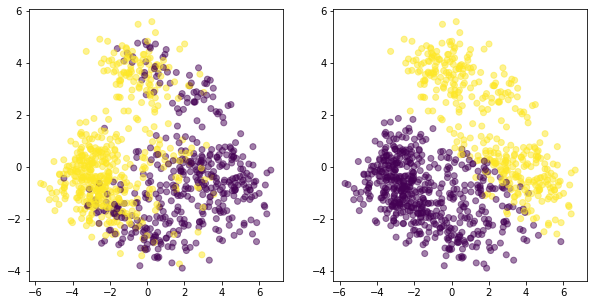

Comparing the assigned categories to the ones in the data:
col_0          0    1
is_fastball          
0            191  236
1            361  134
Adjusted Rand Score: 0.08588899428120987


In [10]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Define features and ground truth
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['is_fastball']
X_norm = StandardScaler().fit_transform(X)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

bandwidth = estimate_bandwidth(X_norm, quantile=.05, n_samples=100)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_preds = ms.fit_predict(X_norm)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pitches['is_fastball'], alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, labels))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, cluster_preds)))

[32.93 50.37]
Number of estimated clusters: 3


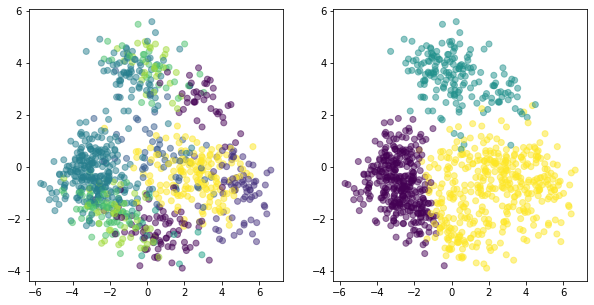

Comparing the assigned categories to the ones in the data:
col_0           0   1    2
n_pitch_type              
0              12  31   70
1               0   0   72
2               5  11   42
3             228  75   21
4               0   0   10
5              64  29   10
6              34  29   19
7               1   1  158
Adjusted Rand Score: 0.2318831156125073


In [11]:
# Define features and outcome
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['n_pitch_type']
X_norm = StandardScaler().fit_transform(X)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

bandwidth = estimate_bandwidth(X_norm, quantile=.02, n_samples=100)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_preds = ms.fit_predict(X_norm)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pitches['n_pitch_type'], alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, labels))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, labels)))

Meanshift performed very poorly on this model. Based on the silhouette coefficient observed earlier, we know that our data is high density and has significant overlap. Because of this, it's likely MeanShift is shifting several different pitch types up the same slope. I had to set the bandwidth exceptionally low to even detect multiple clusters, so it's likely not the best method for this problem.

Next I tried spectral clustering, both because it was the next one demonstrated in the curriculum and because it's method of similarity comparison might have a better result in drawing out the overlapping cluster relationships. Because spectral clustering assumes similar sized clusters, I resampled the data to accommodate for this

[82.6 92.8]


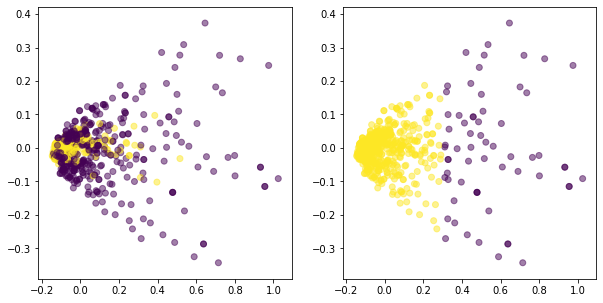

Comparing the assigned categories to the ones in the data:
col_0   0    1
row_0         
0      59  436
1       5  490
Adjusted Rand Score: 0.011659118442838177


In [12]:
# Test with Spectral Clustering
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import SpectralClustering

# Define features and outcome
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['is_fastball']

ros = RandomOverSampler(random_state=0)
X_rs, y_rs = ros.fit_resample(X, y)
X_norm = normalize(X_rs)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

# Declare and fit the model.
sc = SpectralClustering(n_clusters=2)
sc.fit(X_norm)

#Predicted clusters.
predict=sc.fit_predict(X_norm)

#Graph results.
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_rs, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict, alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_rs, predict))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y_rs, predict)))

[82.39 92.82]


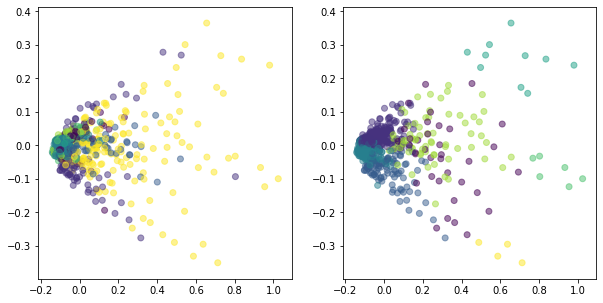

Comparing the assigned categories to the ones in the data:
col_0          0    1   2    3  4  5   6  7
n_pitch_type                               
0              0   70  10   30  0  0   3  0
1              2   12  46    5  2  1   4  0
2              7   16   4   12  0  0  19  0
3              0  177   0  142  0  0   5  0
4              0   10   0    0  0  0   0  0
5              0   73   0   30  0  0   0  0
6              0   52   0   30  0  0   0  0
7             28   33  33   12  8  5  37  4
Adjusted Rand Score: 0.11284251900420181


In [13]:
# Define features and outcome
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['n_pitch_type']
X_norm = normalize(X)

pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

# Declare and fit the model.
sc = SpectralClustering(n_clusters=8)
sc.fit(X_norm)

#Predicted clusters.
predict=sc.fit_predict(X_norm)

#Graph results.
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pitches['n_pitch_type'], alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict.ravel(), alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, predict)))

Spectral clustering was surprising; while both models performed poorly, the model to predict pitch type performed marginally better. Unlike the K-Means models, spectral clustering performed significantly better with a normalizing function versus StandardScaler, although both model types were less representative of the ground truth than the K-Means above.

I attempted to use affinity propagation, but it's performance was too poor to bother including. For my final model, I researched a method to implement gaussian mixture modeling. Gaussian mixture modeling is a form of soft clustering and is noted for better performance with overlapping data, which potentially makes it a good model for this data set. 

[32.93 50.37]


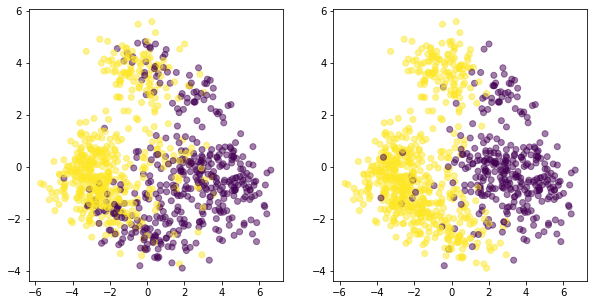

Comparing the assigned categories to the ones in the data:
col_0          0    1
is_fastball          
0            266  161
1             58  437
Adjusted Rand Score: 0.2745052901585567


In [14]:
# Test with Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Define features and outcome
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['is_fastball']
X_norm = StandardScaler().fit_transform(X)

# Reduce features for graphical purposes
pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

# Initialize and fit
gmm = GaussianMixture(n_components=2)
pred = gmm.fit_predict(X_norm)

# Plot PCA components
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, pred))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, pred)))

[32.93 50.37]


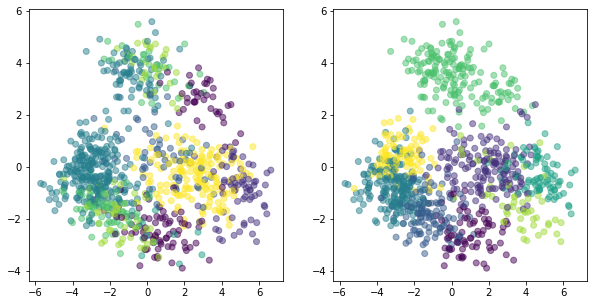

Comparing the assigned categories to the ones in the data:
col_0          0   1   2    3   4   5   6   7
n_pitch_type                                 
0             51   7  19    2   3  30   1   0
1              0   3   0    0  51   0  18   0
2              0  38   1    0   1   8   4   6
3              1   8  21  140   0  73   0  81
4              8   0   2    0   0   0   0   0
5              0   0  37   36   0  29   1   0
6              7   0  34   11   0  30   0   0
7              5  94   4    0  27   1  28   1
Adjusted Rand Score: 0.25838689268482434


In [15]:
# Define features and outcome
X = pitches.drop(['is_fastball', 'n_pitch_type'], 1)
y = pitches['n_pitch_type']
X_norm = StandardScaler().fit_transform(X)

# Reduce features for graphical purposes
pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var)

# Initialize and fit
gmm = GaussianMixture(n_components=8)
pred = gmm.fit_predict(X_norm)

# Plot PCA components
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.5)

plt.subplot(1,2,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, pred))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, pred)))

This mixture model is interesting. Although the Rand Index is lower than our base K-Means model at determining clusters for fastball versus offspeed pitches, gaussian mixture modeling seems to capture the relationship between the clusters for ground truth far better than any prior model. For pitch type, this model wins outright on Rand Index alone.

So it seems the primary challenge in this problem is the overlapping nature of the data. It's likely that this stems from similarity in the pitch movement between pitches that are and are not fastballs. For example, splitters move similarly to curveballs and cutters move similarly to sliders; the main difference in these pairs is the speed at which they're thrown. I conclude that this accounts for the increased performance of the models in predicting 'fastball-or-not' versus predicting the actual type but due to the similarity, many pitches that are fastballs are being classified as not since many of their characteristics (aside from velocity) are more similar to offspeed pitches than fastballs.

This model also emphasizes an interesting point: while we may give designations to similar pitches based on observation, these models may actually group these pitches better than the arbitrary designations do. This type of model may provide a more accurate way of representing pitches based on type than the pitch type variable does, or at least, may provide additional clarity on the type of a pitch. I would use these predictions as features in additional studies with the expectation being that this model may generate useful features for supervised tasks with the data set.

Finally, I conclude that for the binary task of predicting fastballs versus offspeed, the K-Means model was actually the best performer when assessed against the ground truth. Alternatively, the Gaussian Mixture Model performed the best at predicting pitch type, due to its soft clustering determining degrees of membership between clusters, although it only predicted pitch types incrementally better than K-Means. Considering both tasks presented to it, the K-Means model was the best performer overall.